Based on the sheets of the OII Course: Statistical Analysis of Networks \
**Professor**: Prof. Renaud Lambiotte

**Author**: John Pougué-Biyong \
Contact: john.pougue-biyong@maths.ox.ac.uk

**Tutor**: Nicola Pedreschi

*25 June 2024*

# 1. Introduction to networks and basic metrics

In [1]:
#!pip install scipy==1.8.1
import scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

A common library for network analysis in Python is [NetworkX](https://networkx.org/). We first [install the library ](https://networkx.org/documentation/stable/install.html) and import it into our notebook.

In [2]:
#!pip install networkx --upgrade
import networkx as nx

## Basics of NetworkX
NetworkX enables to easily create a network, add/remove nodes & edges, and subsequently analyse and draw the network. The library documentation can be found [here](https://networkx.org/documentation/stable/tutorial.html). Let's do it! We first create an undirected network.

In [3]:
G = nx.Graph()

We add 5 edges

In [4]:
list_of_edges = [(1, 2), (1, 3), (1, 4), (2, 3), (4, 2)]
G.add_edges_from(list_of_edges)
print(G.edges) # display the edges in G

[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4)]


We can also add a node as follows

In [5]:
G.add_node(5)
print(G.nodes) # display the nodes in G

[1, 2, 3, 4, 5]


The method `print` provides a short summary of the network...

In [6]:
print(G)

In [7]:
pip install decorator==5.0.9


Note: you may need to restart the kernel to use updated packages.


... And the `draw` method displays the network.

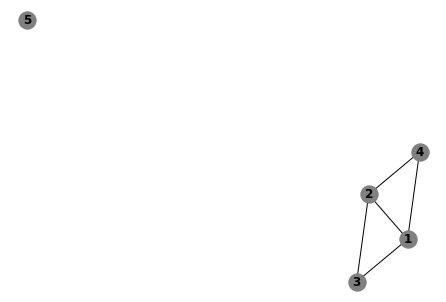

In [8]:
nx.draw(G, with_labels=True, font_weight='bold', node_color='grey')

We will see later how to [enrich the network with node/edge attributes](https://networkx.org/documentation/stable/tutorial.html#adding-attributes-to-graphs-nodes-and-edges), and [display the network with all this information](https://networkx.org/documentation/stable/tutorial.html#drawing-graphs).

## Network analysis with NetworkX
Once a network is built, we can analysis it by calling the plethora of [algorithms available in the NetworkX library](https://networkx.org/documentation/stable/reference/algorithms/index.html). As a matter of example, let's analyse the [Zachary's karate club network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

Zachary's Karate Club


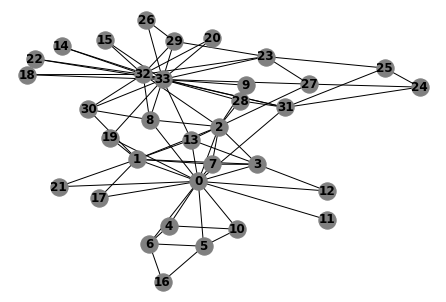

In [9]:
K = nx.karate_club_graph()
print(K)
nx.draw(K, with_labels=True, font_weight='bold', node_color='grey')

### Degree distribution
Let's display the degree distribution of K. We can access the degree of a node `n` simply with `K.degree[n]`.

In [10]:
K.degree[3]

6

Let's compute the degrees then! 

In [11]:
degrees = [K.degree[n] for n in K.nodes]

... And print the degree distribution.

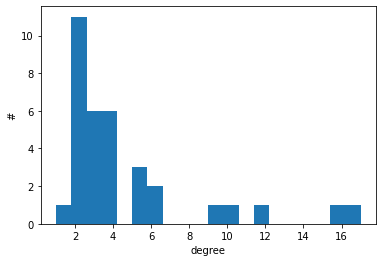

In [12]:
plt.hist(degrees, bins=20)
plt.xlabel('degree')
plt.ylabel('#')
plt.show()

## *Bonus*: number of walks between two nodes
The Dijsktra's algorithm uses a heuristic to find the shortest path between 2 nodes in a connected graph. Another important property to quantify the indirect relation between two nodes is the number of walks between them. The number of walks of length k between nodes $i$ and $j$ is the $(i,j)$-entry of the $k$-th power of the adjacency matrix $A$, i.e  $A^k(i, j)$.

Let's verify this property for any graph of our choice.

In [13]:
A = nx.adjacency_matrix(G)
print(A)

  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (2, 0)	1
  (2, 1)	1
  (3, 0)	1
  (3, 1)	1


In [14]:
print(A.dot(A).dot(A))

  (0, 1)	5
  (0, 3)	5
  (0, 2)	5
  (0, 0)	4
  (1, 0)	5
  (1, 3)	5
  (1, 2)	5
  (1, 1)	4
  (2, 0)	5
  (2, 3)	2
  (2, 2)	2
  (2, 1)	5
  (3, 0)	5
  (3, 3)	2
  (3, 2)	2
  (3, 1)	5


# 2. Random Graph models & Network motifs

## Degree-preserving graph randomisation
Degree-preserving graph randomisation is essential to assess whether some patterns in a given graph are inherent to the graph structure, or if they are just the result of *chance*. 
If the patterns persist even after edge randomisation, they are less likely to be *accidental*. Let's randomise the [Zachary's karate club network](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

Zachary's Karate Club


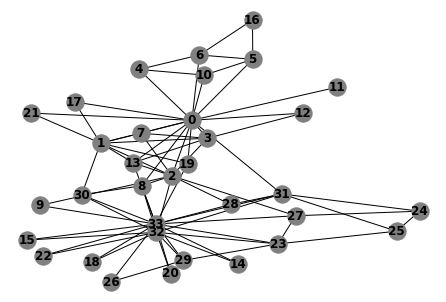

In [15]:
G = nx.karate_club_graph()
print(G)
nx.draw(G, with_labels=True, font_weight='bold', node_color='grey')

In [16]:
degree_sequence_before_randomisation = sorted((d for n, d in G.degree()), reverse=True)

The idea is to perform a randomisation via operations that preserve the degrees, as described in https://en.wikipedia.org/wiki/Degree-preserving_randomization. This approach is an alternative to generating a graph via the configuration model for instance.
To preserve the degree of each node, the trick is to repeatedly take 2 random edges and swap one of their nodes respectively. We also need to make sure that the 2 selected edges do not have a node in common, as this could introduce a self-loop on the node they have in common (you can convince yourself of this with a simple sketch).

In [17]:
import random as rd 
def randomise_graph(graph, nb_trials=50):
    for _ in range(nb_trials):
        selected = rd.sample(list(graph.edges()), 2)
        edgeA, edgeB = selected[0], selected[1]
        intersection = list(set(edgeA) & set(edgeB))
        if len(intersection) == 0:
            new_edgeA = (edgeA[0], edgeB[1])
            new_edgeB = (edgeB[0], edgeA[1])
            if new_edgeA not in graph.edges() and new_edgeB not in graph.edges():
                graph.remove_edges_from([edgeA, edgeB])
                graph.add_edges_from([new_edgeA, new_edgeB])
    return graph 

G = randomise_graph(G, nb_trials=50)
degree_sequence_after_randomisation = sorted((d for n, d in G.degree()), reverse=True) 

Let's make sure that the degree distribution is well conserved...

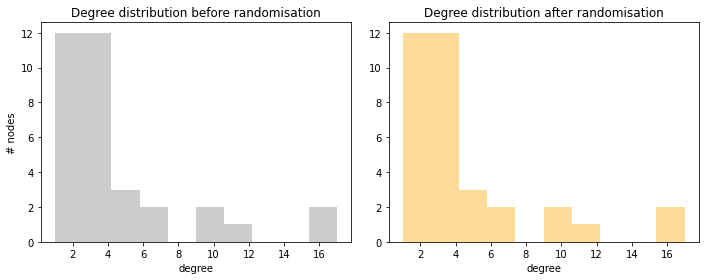

In [18]:
import matplotlib.pyplot as plt
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

ax0.hist(degree_sequence_before_randomisation, histtype='stepfilled', color='grey', alpha=.4)
ax0.set_title("Degree distribution before randomisation")
ax0.set_xlabel("degree")
ax0.set_ylabel("# nodes")

ax1.hist(degree_sequence_after_randomisation, histtype='stepfilled', color='orange', alpha=.4)
ax1.set_title("Degree distribution after randomisation")
ax1.set_xlabel("degree")

fig.tight_layout()
plt.show()

### Number of triangles
We are going to check if the number of triangles is conserved after randomisation (see [nx.triangles](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.triangles.html) for documentation). Intuitively, redirecting edges should break triangles. 

In [19]:
def compute_number_triangles(graph):
    triangles_per_node = nx.triangles(graph) 
    # note that each triangle is counted 3 times (for each of its nodes)
    number_of_triangles = sum(triangles_per_node.values()) / 3 
    return number_of_triangles
actual_number_of_triangles = compute_number_triangles(nx.karate_club_graph())
print('actual number of triangles:', actual_number_of_triangles)

actual number of triangles: 45.0


In [20]:
iterations = 100
expected_number_of_triangles = 0
for _ in range(iterations):
    G = randomise_graph(nx.karate_club_graph(), nb_trials=50)
    expected_number_of_triangles += compute_number_triangles(G)
print('expected number of triangles:', expected_number_of_triangles / iterations) 

expected number of triangles: 39.05


In expectation over several randomisations, the number of triangles has decreased. This means that the selected social network displays an intrinsic **social mechanism** that is quite common: **the friend of my friend is likelier to be my friend, compared to an individual selected at random in the population**. 

# 3. Community structure


## Accuracy of the Louvain algorithm
On SBMs with two communities, we explore the accuracy of Louvain to find back the two communities as a function of the parameters $p_{in}$ and $p_{out}$ of the affinity matrix.

In [21]:
pip install python-louvain

Note: you may need to restart the kernel to use updated packages.


In [22]:
import networkx as nx
from community import community_louvain
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score

In [23]:
def detect_communities(G):
    """ 
    This function applies the Louvain algorithm to a given nx.Graph G. 
    """
    partition = community_louvain.best_partition(G, resolution=1.)
    communities = list(partition.values())
    return communities

In [24]:
def compute_accuracy_louvain(left_size, right_size, it=3):
    """ 
    This function applies the Louvain algorithm to many network simulations, 
    for different values of p_in and p_out.
    left and right_size are the sizes of the two communities.
    """
    ground_truth = [0] * left_size + [1] * right_size
    community_sizes = [left_size, right_size]
    p_in_range = np.arange(.2, 1., .1)
    p_out_range = np.arange(.1, .9, .1)
    accuracy = {}
    for p_in in p_in_range:
        accuracy[p_in] = {}
        for p_out in p_out_range:
            accuracy[p_in][p_out] = 0
            affinity_matrix = [[p_in, p_out], 
                               [p_out, p_in]]
            for _ in range(it):
                G = nx.stochastic_block_model(community_sizes, affinity_matrix)
                communities = detect_communities(G)
                accuracy[p_in][p_out] += nmi_score(communities, ground_truth) / it
    return accuracy

In [25]:
left_size = 100
right_size = 100
accuracy = compute_accuracy_louvain(left_size, right_size, it=3)

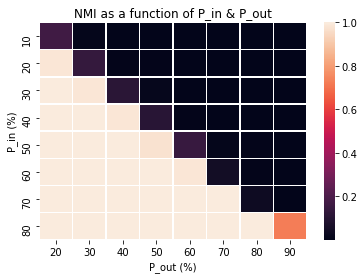

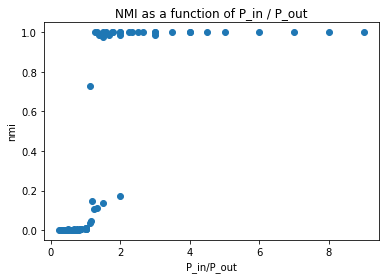

In [26]:
def draw_results(accuracy):
    heatmap = np.zeros((len(accuracy), len(accuracy)))
    point_cloud = {'x': [], 'y': []}
    for idx, x in enumerate(accuracy):
        for idy, y in enumerate(accuracy[x]):
            acc = accuracy[x][y]
            heatmap[idx][idy] = acc
            point_cloud['x'] += [x / y]
            point_cloud['y'] += [acc]

    ax0 = sns.heatmap(heatmap, linewidth=0.5)
    ax0.set_xticklabels(range(20, 91, 10))
    ax0.set_yticklabels(range(10, 81, 10))
    ax0.set_ylabel('P_in (%)')
    ax0.set_xlabel('P_out (%)')
    ax0.set_title('NMI as a function of P_in & P_out')
    plt.show()

    plt.scatter(point_cloud['x'], point_cloud['y'])
    plt.xlabel('P_in/P_out')
    plt.ylabel('nmi')
    plt.title('NMI as a function of P_in / P_out')
    plt.show() 

draw_results(accuracy)

We observe that **the Louvain algorithm is a good community detection method for assortative networks**, i.e. networks where nodes connect more to nodes in their community, than with nodes in other communities ($p_{in} > p_{out}$).

# 4. Linear dynamics and time-scale separation


The master equation for continuous time random walk is $x(t) = e^{t L} x_0$, where $L$ is the normalised laplacian.

In this section, we try reproduce Figure B below: we let the master equation evolve, when the walks starts all on the President (top row) or the Instructor (bottom row) at $t=0$. We plot the distribution of location of the walks at time $t$ for 3 different times. We use colors to distinguish between blue and red nodes.

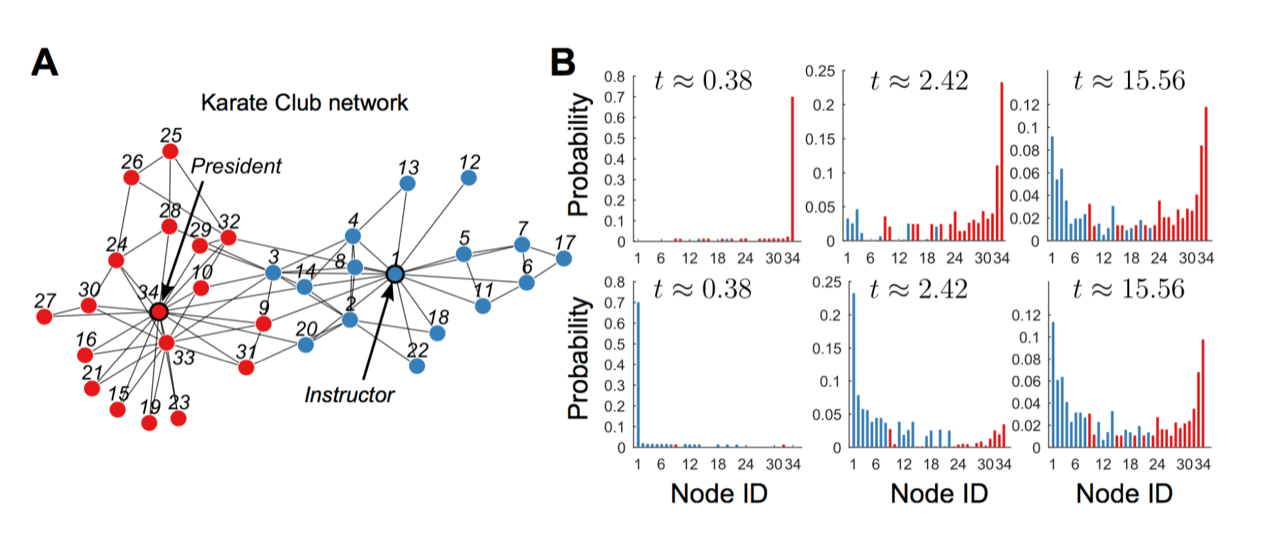

In [27]:
from IPython.display import Image
Image("img.png")

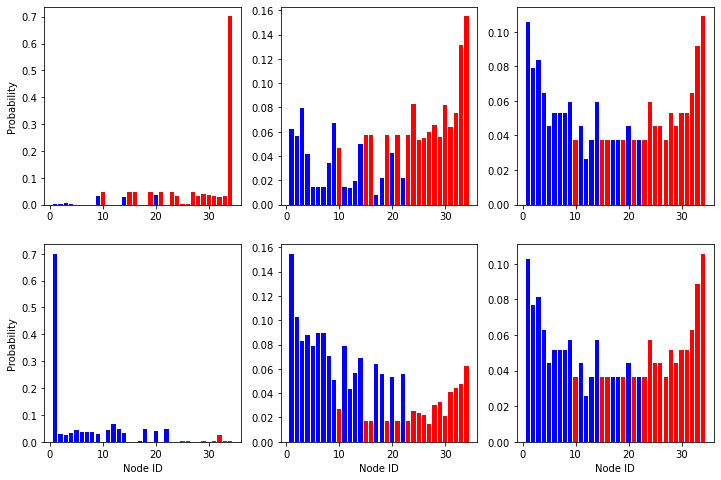

In [28]:
from scipy.sparse.csgraph import laplacian
from scipy.linalg import expm
import matplotlib.pyplot as plt

G = nx.karate_club_graph()
color_mapping = []
for idx in range(34):
    side = G.nodes[idx]["club"]
    if side == "Mr. Hi":
        color_mapping += ["blue"]
    elif side == "Officer":
        color_mapping += ["red"] 

A = nx.adjacency_matrix(G).todense()
L = laplacian(A, normed = True) 
x0_president = np.array([0] * 33 + [1]).T
x0_instructor = np.array([1] + [0] * 33).T

fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))  
node_ids = list(range(1, 35))
for _, t in enumerate([.38, 5.42, 105.56]):
    exptL = expm(-t*L)
    xt_president = exptL.dot(x0_president)
    xt_instructor = exptL.dot(x0_instructor)
    ax[0][_].bar(node_ids, xt_president, color=color_mapping)
    ax[1][_].bar(node_ids, xt_instructor, color=color_mapping)
    ax[1][_].set_xlabel('Node ID')
ax[0][0].set_ylabel('Probability')
ax[1][0].set_ylabel('Probability')
plt.show()